# Extracting symbols from image using `OpenCV`

In [1]:
import os
import pickle
import cv2
import numpy as np
from functools import cmp_to_key
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf

from tensorflow import keras
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
def extractSymbols(imgOrig, showSteps = False):
    debugImgSteps = []
    imgGray = cv2.cvtColor(imgOrig,cv2.COLOR_BGR2GRAY)
    imgFiltered = cv2.medianBlur(imgGray, 5)
    debugImgSteps.append(imgFiltered)
    
    imgCanny = cv2.Canny(imgFiltered, 50,180)
    debugImgSteps.append(imgCanny)

    kernel = np.ones((5,5), np.uint8)
    imgDilated = cv2.dilate(imgCanny, kernel, iterations=5)
    debugImgSteps.append(imgDilated)

    contours, _= cv2.findContours(imgDilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    boundingBoxes = []
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        boundingBoxes.append((x,y,w,h))

    global rowsG
    rowsG, _, _ = imgOrig.shape
    key_leftRightTopBottom = cmp_to_key(leftRightTopBottom)
    boundingBoxes = sorted(boundingBoxes, key=key_leftRightTopBottom)

    symbols = []
    for (i, box) in enumerate(boundingBoxes):
        x,y,w,h = box
        mathSymbol = imgOrig[y:y+h, x:x+w]
        mathSymbol = cv2.cvtColor(mathSymbol, cv2.COLOR_BGR2GRAY) #converting to Gray as tensorflow deals with grayscale or RGB, not BGR
        mathSymbol = cv2.resize(mathSymbol, (45,45), interpolation=cv2.INTER_AREA) #to have the same size as trained images in the dataset
        debugImgSteps.append(mathSymbol)
        mathSymbolF = mathSymbol.astype('float32') #optional: tensorflows deals with float32, not uint8
        symbols.append(mathSymbolF)

    if showSteps:
        dispImages(debugImgSteps)

    return symbols
        

In [3]:
def leftRightTopBottom(tup1, tup2):
    x1, y1, _, _ = tup1
    x2, y2, _, _ = tup2
    rows = rowsG
    yRegion1, yRegion2 = -1, -1

    for i in range(8):
        if y1 < rows/8 + rows*(i/8):
            yRegion1 = i
            break
    else:
        if yRegion1 == -1:
            yRegion1 = 8

    for i in range(8):
        if y2 < rows/8 + rows*(i/8):
            yRegion2 = i
            break
    else:
        if yRegion2 == -1:
            yRegion2 = 8
    
    if yRegion1 < yRegion2:
        return -1
    elif yRegion2 < yRegion1:
        return 1
    elif x1 <= x2:
        return -1
    else:
        return 1


In [4]:
def dispImages(imgs):
    for img in imgs:
        cv2.imshow('Image', img)
        cv2.waitKey(0)
    else:
        cv2.destroyAllWindows()

In [6]:
img = cv2.imread('tests/testMath6.png')
symbols = extractSymbols(img, showSteps=True)

# Creating dictionary that maps folder names to latex

example of folder names in "mathSymbolsDataset": <br>
<img src="guideImages/datasetFolders.png" width=400 height=300>

using `r` to make the string `raw` to avoid confusing strings like `\n` with python's new line <br>
however, the values will now have two backslashes (e.g. `\\n`), thus, we will later need to replace each `\\` with `\`

In [5]:
dic = {
    "-": r"-",
    "!": r"!",
    "(": r"(",
    ")": r")",
    ",": r",",
    "[": r"[",
    "]": r"]",
    "{": r"\{",
    "}": r"\}",
    "+": r"+",
    "=": r"=",
    "0": r"0",
    "1": r"1",
    "2": r"2",
    "3": r"3",
    "4": r"4",
    "5": r"5",
    "6": r"6",
    "7": r"7",
    "8": r"8",
    "9": r"9",
    "A": r"\A",
    "alpha": r"\alpha",
    "b": r"b",
    "beta": r"\beta",
    "C": r"\C",
    "cos": r"\cos",
    "d": r"d",
    "Delta": r"\Delta",
    "div": r"\div",
    "e": r"exp()",
    "exists": r"\exists",
    "f": r"f",
    "forall": r"\forall",
    "forward_slash": r"/",
    "G": r"\G",
    "gamma": r"\gamma",
    "geq": r"\geq",
    "gt": r">",
    "H": r"\H",
    "i": r"i",
    "in": r"\in",
    "infty": r"\infty",
    "int": r"\int",
    "j": r"j",
    "k": r"k",
    "l": r"l",
    "lambda": r"\lambda",
    "ldots": r"\ldots",
    "leq": r"\le",
    "lim": r"\lim",
    "log": r"\log",
    "lt": r"<",
    "M": r"\M",
    "mu": r"\mu",
    "N": r"\N",
    "neq": r"\neq",
    "o": r"\O",
    "p": r"p",
    "phi": r"\Phi",
    "pi": r"\Pi",
    "pm": r"\pm",
    "q": r"q",
    "R": r"\R",
    "rightarrow": r"\rightarrow",
    "S": r"\S",
    "sigma": r"\sigma",
    "sin": r"\sin",
    "sum": r"\sum",
    "T": r"\T",
    "tan": r"\tan",
    "theta": r"\theta",
    "times": r"\times",
    "u": r"u",
    "v": r"v",
    "w": r"w",
    "X": r"\X",
    "y": r"y",
    "z": r"z"
}

# Preparing the dataset

## Reading the kaggle [dataset](https://www.kaggle.com/datasets/xainano/handwrittenmathsymbols?resource=download)

Steps:
1. create a list of images and another list of labels for each image
2. store them in pickle files for easy retrieval when re-running the code 

In [7]:
def loadData(dataDir):
    imgs = []
    labels = []
    for key, value in dic.items():
        path = os.path.join(dataDir, key)
        for imgName in os.listdir(path):
            try:
                img = cv2.imread(os.path.join(path, imgName), cv2.COLOR_BGR2GRAY) 
                imgs.append(img)
                labels.append(value)
            except Exception as e:
                print(e)    
    return (imgs, labels)

The following cell is commented as it takes a long time (10min if image RGB, 1min otherwise) to create the pickle files

In [10]:
#imgs, labels = loadData('mathSymbolsDataset/')
#with open("x_symbols.pickle", 'wb') as f:
#    pickle.dump(imgs, f)
#with open("y_latex.pickle", 'wb') as f:
#    pickle.dump(labels, f)

In [8]:
with open("x_symbols.pickle", 'rb') as f:
    imgs = pickle.load(f)
with open("y_latex.pickle", 'rb') as f:
    labels = pickle.load(f)

## converting text labels (latex) to numeric codes

In [9]:
latexToNums = {k: v for v, k in enumerate(np.unique(labels))}
#this dictionary is to revert the predicted numeric code back to latex: 
numsToLatex = {v: k for v, k in enumerate(np.unique(labels))}
latexToNums

{'!': 0,
 '(': 1,
 ')': 2,
 '+': 3,
 ',': 4,
 '-': 5,
 '/': 6,
 '0': 7,
 '1': 8,
 '2': 9,
 '3': 10,
 '4': 11,
 '5': 12,
 '6': 13,
 '7': 14,
 '8': 15,
 '9': 16,
 '<': 17,
 '=': 18,
 '>': 19,
 '[': 20,
 '\\A': 21,
 '\\C': 22,
 '\\Delta': 23,
 '\\G': 24,
 '\\H': 25,
 '\\M': 26,
 '\\N': 27,
 '\\O': 28,
 '\\Phi': 29,
 '\\Pi': 30,
 '\\R': 31,
 '\\S': 32,
 '\\T': 33,
 '\\X': 34,
 '\\alpha': 35,
 '\\beta': 36,
 '\\cos': 37,
 '\\div': 38,
 '\\exists': 39,
 '\\forall': 40,
 '\\gamma': 41,
 '\\geq': 42,
 '\\in': 43,
 '\\infty': 44,
 '\\int': 45,
 '\\lambda': 46,
 '\\ldots': 47,
 '\\le': 48,
 '\\lim': 49,
 '\\log': 50,
 '\\mu': 51,
 '\\neq': 52,
 '\\pm': 53,
 '\\rightarrow': 54,
 '\\sigma': 55,
 '\\sin': 56,
 '\\sum': 57,
 '\\tan': 58,
 '\\theta': 59,
 '\\times': 60,
 '\\{': 61,
 '\\}': 62,
 ']': 63,
 'b': 64,
 'd': 65,
 'exp()': 66,
 'f': 67,
 'i': 68,
 'j': 69,
 'k': 70,
 'l': 71,
 'p': 72,
 'q': 73,
 'u': 74,
 'v': 75,
 'w': 76,
 'y': 77,
 'z': 78}

## Splitting the data into train and test data

Note that `stratify` is used to split the dataset into train and test sets <br> 
in a way that preserves the same proportions of examples in each class as observed in the original dataset <br>
[(source)](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/#:~:text=is%20desirable%20to-,split%20the%20dataset%20into,stratified%20train-test%20split.,-We%20can%20achieve)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.33, stratify=labels, random_state=42)

In [46]:
y_train[1]

'd'

## Normalizing image pixels

In [30]:
x_train = tf.keras.utils.normalize(x_train, axis=1) #similar to dividing by 255 (but not equivalent in result)
x_test = tf.keras.utils.normalize(x_test, axis=1) #Also, don't know why we are using "axis=1" specifically, but that's what's normally used with image normalization

### Converting `y` labels to numeric codes instead of strings
Because `keras` models accept numbers not strings

In [33]:
dispImages([x_train[4]])

In [11]:
y_train_nums = [latexToNums[latex] for latex in y_train]
y_test_nums = [latexToNums[latex] for latex in y_test]
y_train_nums

[58,
 65,
 10,
 62,
 5,
 9,
 31,
 34,
 77,
 3,
 34,
 5,
 11,
 9,
 34,
 30,
 21,
 5,
 5,
 14,
 27,
 5,
 5,
 10,
 77,
 64,
 21,
 34,
 8,
 34,
 3,
 27,
 16,
 67,
 5,
 18,
 34,
 3,
 77,
 3,
 5,
 8,
 18,
 56,
 5,
 9,
 8,
 1,
 34,
 5,
 45,
 9,
 15,
 60,
 8,
 11,
 50,
 8,
 1,
 22,
 21,
 9,
 21,
 63,
 9,
 5,
 9,
 26,
 31,
 60,
 9,
 3,
 18,
 3,
 34,
 8,
 5,
 66,
 34,
 21,
 15,
 30,
 49,
 5,
 10,
 3,
 14,
 5,
 7,
 18,
 67,
 49,
 37,
 37,
 16,
 10,
 5,
 56,
 15,
 5,
 10,
 11,
 2,
 22,
 8,
 64,
 73,
 27,
 66,
 22,
 8,
 59,
 36,
 34,
 8,
 9,
 5,
 77,
 8,
 18,
 30,
 26,
 3,
 70,
 16,
 18,
 64,
 1,
 78,
 1,
 5,
 34,
 34,
 9,
 10,
 8,
 60,
 1,
 12,
 36,
 5,
 23,
 5,
 27,
 34,
 8,
 0,
 49,
 34,
 9,
 3,
 48,
 5,
 57,
 59,
 3,
 2,
 21,
 69,
 21,
 49,
 3,
 34,
 12,
 5,
 2,
 5,
 73,
 34,
 5,
 5,
 41,
 24,
 3,
 3,
 14,
 64,
 27,
 77,
 34,
 7,
 58,
 50,
 22,
 7,
 26,
 10,
 68,
 5,
 5,
 78,
 3,
 59,
 12,
 77,
 78,
 8,
 8,
 8,
 50,
 47,
 65,
 5,
 72,
 37,
 3,
 3,
 34,
 37,
 9,
 56,
 9,
 16,
 8,
 5,
 14,
 27,
 

### Making sure all datasets are `ndarray` not `list`
Because `keras` models accept `ndarray`

In [16]:
type(x_train), type(x_test), type(y_train_nums), type(y_test_nums)

(numpy.ndarray, numpy.ndarray, list, list)

In [17]:
y_train_nums = np.array(y_train_nums)
y_test_nums = np.array(y_test_nums)

In [18]:
type(y_train_nums), type(y_test_nums)

(numpy.ndarray, numpy.ndarray)

## Creating the model

### 1. Sequential vs Functional models

* Sequential is a linear stack of layers. In other words, the layer `i` is connected only to layers `i-1` and `i+1`
* Functional is more dynamic, as each layer can connect to any other layer in the neural network

Since the images are small in size, and the problem is relatively simple, we'll use a sequential model

In [19]:
model = tf.keras.models.Sequential()

### 2. Model layers

In [20]:
# for easier processing: flatten image (e.g. 45x45 will become 1x2025)
model.add(tf.keras.layers.Flatten())
# 128 nodes are chosen as they are a power of 2 (2^7) which makes computation easier, and the images are not large (45x45) so 128 nodes should suffice
# relu is the default activation function to use
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
# add another layer because if you have one, then you're getting linear relations only between the image's features, while two layers makes it non-linear
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
# number of classifications == number of stored latex strings == len(latexToNums) == 79
# using softmax as it converts the scores to a normalized probability distribution
model.add(tf.keras.layers.Dense(len(latexToNums), activation=tf.nn.softmax))

### 3. Model compilation

In [21]:
# "compiling" means passing the settings for actually optimizing/training the model we've defined
model.compile(optimizer='adam', # same logic as relu, great default optimizer to start with
              loss='sparse_categorical_crossentropy', # A neural network doesn't actually attempt to maximize accuracy. It attempts to minimize loss, this loss function is also a great default
              metrics=['accuracy']) # ratio between the number of correct predictions to the total number of predictions.

### 4. Model training

"A good rule of thumb is to start with a value that is 3 times the number of columns in your data." <br>
[(source)](https://gretel.ai/gretel-synthetics-faqs/how-many-epochs-should-i-train-my-model-with) <br>
Therefore, we start by with 45*3 = 135 epochs (i.e. number of passes of the entire training dataset the machine learning algorithm has completed)

In [22]:
#model.fit(x_train, y_train_nums, epochs=135)

### 5. Save the model for later use

Technical note: pickle doesn't save models correctly, as it outputs this error when loading the pickle file: <br><br>
FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://0eb44777-6983-466e-ac15-adfa9d3dae07/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'. <br><br>
 That's why we are using keras's `save()` and `load_model()`

In [23]:
#model.save("nnModel")

### 6. Load the model

In [6]:
model = keras.models.load_model("nnModel")

In [51]:
symbols[0].reshape(1,45,45).shape

(1, 45, 45)

In [119]:
symTest = symbols[8]

In [120]:
print(np.argmax(model.predict(symTest.reshape(1,45,45))))

11


## Farah's Trial

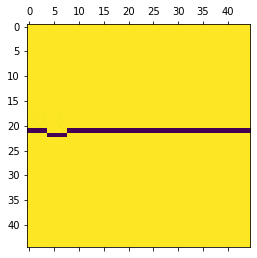

In [39]:
plt.matshow(x_train[4])

In [12]:
x_train_original = np.copy(x_train)

In [13]:
x_train_original[0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [14]:
for i in range(len(x_train)):
    x_train[i] = x_train[i].reshape(45*45)
x_train[0]

array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)

In [15]:
y_train = np.array(y_train)
x_train = np.array(x_train)

In [28]:
y_train = y_train.astype(np.float64)

ValueError: could not convert string to float: '\\tan'

In [27]:
new_model = keras.Sequential([
    keras.layers.Dense(79,input_shape=(2025,), activation='sigmoid')
    ])
new_model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
new_model.fit(x_train, y_train, epochs=5)

Epoch 1/5


UnimplementedError: Graph execution error:

Detected at node 'Cast_1' defined at (most recent call last):
    File "C:\Users\Farah\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Farah\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Farah\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\Farah\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\Farah\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\ipykernel\kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\ipykernel\kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\ipykernel\kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Farah\AppData\Local\Temp\ipykernel_22600\4057371436.py", line 9, in <cell line: 9>
      new_model.fit(x_train, y_train, epochs=5)
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\keras\engine\training.py", line 864, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\keras\engine\training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\keras\engine\compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\keras\metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "c:\Users\Farah\Documents\Handwritten-M2L\venv\lib\site-packages\keras\metrics.py", line 720, in update_state
      y_true = tf.cast(y_true, self._dtype)
Node: 'Cast_1'
Cast string to float is not supported
	 [[{{node Cast_1}}]] [Op:__inference_train_function_969]